# Import

In [1]:
import pandas as pd
from pandas import DataFrame
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import *
import itertools

import os

import xgboost as xgb 
from xgboost import plot_importance , XGBClassifier

import lightgbm as lgbm
from lightgbm import LGBMClassifier

from keras.utils.np_utils import to_categorical 
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import *

from tqdm import tqdm, notebook
import time

# Read Data

In [2]:
train_original = pd.read_csv('./open data/train.csv')
test_original = pd.read_csv('./open data/test_x.csv')
train = train_original.copy()
test = test_original.copy()

In [3]:
# fill NA
def fill_married(data):
    pdata = data.copy()
    pdata.loc[ (pdata.married==0)&(pdata.age_group=='10s'),'married' ] = 1
    pdata.loc[ (pdata.married==0)&(pdata.age_group=='20s'),'married' ] = 1
    pdata.loc[pdata.married==0,'married'] = 2
    
    return pdata

def fill_education(data):
    pdata = data.copy()
    pdata.loc[(pdata.education==0)&(pdata.age_group=='10s'),'education'] = 2
    pdata.loc[pdata.education==0,'education'] = 3

    return pdata

def fill_engnat(data):
    pdata = data.copy()
    pdata.loc[pdata.engnat==0,'engnat'] = 1
    
    return pdata

def fill_hand(data):
    pdata = data.copy()
    pdata.loc[pdata.hand==0,'hand'] = 1
    
    return pdata
# feature engineering
def Mach_score(data):
    pdata = data.copy()
    Answers = []
    for i in range(20):
        Answers.append('Q'+chr(97+i)+'A')
    reverse_col = ['QeA','QfA','QkA','QqA','QrA','QaA','QdA','QgA','QiA','QnA']
    for col in reverse_col:
        pdata[col] = -pdata[col]
    pdata['Mach_score'] = pdata[Answers].sum(axis=1)
    
    return pdata

def w_score(data):
    pdata = data.copy()
    wr = []
    wf = []
    for i in range(1,14):
        wr.append(f'wr_{i:02d}')
    for i in range(1,4):
        wf.append(f'wf_{i:02d}')
    
    pdata['wr'] = pdata[wr].sum(axis=1)
    pdata['wf'] = pdata[wf].sum(axis=1)
    
    return pdata

def TIPI(data):
    pdata = data.copy()
    pdata['tp_score_1'] = pdata['tp01'] - pdata['tp06']
    pdata['tp_score_2'] = pdata['tp07'] - pdata['tp02']
    pdata['tp_score_3'] = pdata['tp03'] - pdata['tp08']
    pdata['tp_score_4'] = pdata['tp09'] - pdata['tp04']
    pdata['tp_score_5'] = pdata['tp05'] - pdata['tp10']
    
    return pdata

# drop outlier
def drop_outlier(data, datatype):
    
    assert datatype == 'train' or datatype=='test', 'Wrong data type given'
    
    pdata = data.copy()
    if datatype=='train':
        
        out_arr = []
        out_arr.append( np.where(data['familysize']>=16)[0] )
        out_arr.append( np.where(data.wr<=3)[0] )
        out_arr.append( np.where(data.wf>=2)[0] )

        out = []
        for outarr in out_arr:
            out = np.union1d(out, outarr)

        pdata = data.drop(out)
    
    return pdata
# feature banding
def age_band(data):
    pdata = data.copy()
    pdata['age_group'].replace(['10s','20s','30s','40s','50s','60s','+70s'],[1,2,3,4,5,5,5],inplace=True)
    
    return pdata

def E_band(data, num_band):
    pdata = data.copy()
    for i in range(20):
        col = 'Q'+chr(i+97)+'E'
        pdata[col] = pd.qcut(pdata[col],num_band)
        unique = pdata[col].unique()
        pdata[col].replace(unique,range(num_band),inplace=True)
        
    return pdata

def family_band(data):
    pdata = data.copy()
    pdata.loc[pdata.familysize >= 6,'familysize'] = 6
    
    return pdata
# categorical value to numerical value
def cat_gender(data):
    feature = 'gender'
    pdata = data.copy()
    pdata[feature].replace(['Male','Female'],[0,1],inplace=True)
    
    return pdata

def cat_race(data):
    feature = 'race'
    pdata = data.copy()
    unique = ['White', 'Asian', 'Other', 'Black', 'Native American', 'Arab', 'Indigenous Australian']
    pdata[feature].replace(unique,[0,1,2,3,4,5,6],inplace=True)
    
    return pdata

def cat_religion(data):
    feature = 'religion'
    pdata = data.copy()
    unique = ['Other', 'Hindu', 'Agnostic', 'Atheist', 'Christian_Other',
       'Christian_Catholic', 'Muslim', 'Buddhist', 'Christian_Protestant',
       'Jewish', 'Christian_Mormon', 'Sikh']
    pdata[feature].replace(unique,[11,10,0,1,2,3,4,5,6,7,8,9],inplace=True)
    
    return pdata

def cat_num(data):
    pdata = data.copy()
    pdata = cat_gender(pdata)
    pdata = cat_race(pdata)
    pdata = cat_religion(pdata)
    
    return pdata
# drop feature
def drop_feature(data, feature_arr=[]):
    feature_arr += ['index'] 
    
    for i in range(20):
        feature_arr.append('Q'+chr(i+97)+'A')
    for i in range(20):
        feature_arr.append('Q'+chr(i+97)+'E')
    for i in range(1,14):
        feature_arr.append(f'wr_{i:02d}')
    for i in range(1,4):
        feature_arr.append(f'wf_{i:02d}')
    for i in range(1,11):
        feature_arr.append(f'tp{i:02d}')
    

    pdata = data.drop(feature_arr,axis=1)
    
    return pdata


In [4]:
def preprocess(data, datatype, feature_arr=[]):
    
    pdata = data.copy()
    # fill NA
    pdata = fill_married(pdata)
    pdata = fill_education(pdata)
    pdata = fill_engnat(pdata)
    pdata = fill_hand(pdata)
    # feature engineering
    pdata = Mach_score(pdata)
    pdata = w_score(pdata)
    pdata = TIPI(pdata)
    # drop outlier
    pdata = drop_outlier(pdata,datatype)
    # feature banding
    pdata = age_band(pdata)
    pdata = family_band(pdata)
    pdata = E_band(pdata,10)
    # categorical value to numerical value
    pdata = cat_num(pdata)
    # drop feature
    pdata = drop_feature(pdata, feature_arr)
    # unify type of data
    pdata = pdata.astype(np.int)
    
    return pdata

In [5]:
def submission(test_data, model_arr,file_name):
    score = np.zeros((test_data.shape[0],2))
    num_model = len(model_arr)
    for i in range(num_model):
        score += model_arr[i].predict_proba(test_data)
    pred = np.divide(score,num_model)[:,1]
    data = {'index':test['index'],'voted':pred}
    submission = DataFrame(data)
    submission.to_csv('./submission/'+file_name+'.csv',index=False)
    
    return pred

In [6]:
def train_auc(model_arr, data, label):
    score = np.zeros((data.shape[0],2))
    num_model = len(model_arr)
    for i in range(num_model):
        score += model_arr[i].predict_proba(data)
    pred = np.divide(score,num_model)[:,1]
    
    return roc_auc_score(label, pred)

# KFold 

# XGBoost

In [25]:
def xgb_pred(param):
    
    train_x = preprocess(train,'train')
    train_y = train_x['voted']
    train_x = train_x.drop(['voted'],axis=1)
    test_x = preprocess(test,'test')

    model = XGBClassifier(**param)
    
    start_train = time.time()
    model.fit(train_x,train_y, verbose=False)
    print(f'Training : {time.time()-start_train:.2f}s')
    
    print(f'{param["max_depth"]}_{param["n_estimators"]}_{param["learning_rate"]:.3f}_{param["min_child_weight"]:02d}_{param["colsample_bytree"]:.2f}', end=' ')
    pred_auc = train_auc([model], train_x, train_y)
    print(f'{pred_auc:.4f}')
    file_name = f'xgb_{param["max_depth"]}_{param["n_estimators"]}_{param["learning_rate"]:.3f}_{param["min_child_weight"]:02d}_{param["colsample_bytree"]:.2f}_{pred_auc:.4f}'
    submission(test_x,[model],file_name)
    
    return model

In [26]:
opt = { 'max_depth' : 8,
        'n_estimators' : 200,
        'learning_rate' : 0.010,
         'min_child_weight' : 6,
         'colsample_bytree' : 0.8,
        'verbosity' : 0,
        'objective' : 'binary:logistic',
        'booster' : 'gbtree',
        'subsample' : 0.8}

In [27]:
model1 = xgb_pred(opt)

Training : 2.45s
8_200_0.010_06_0.80 0.8067


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

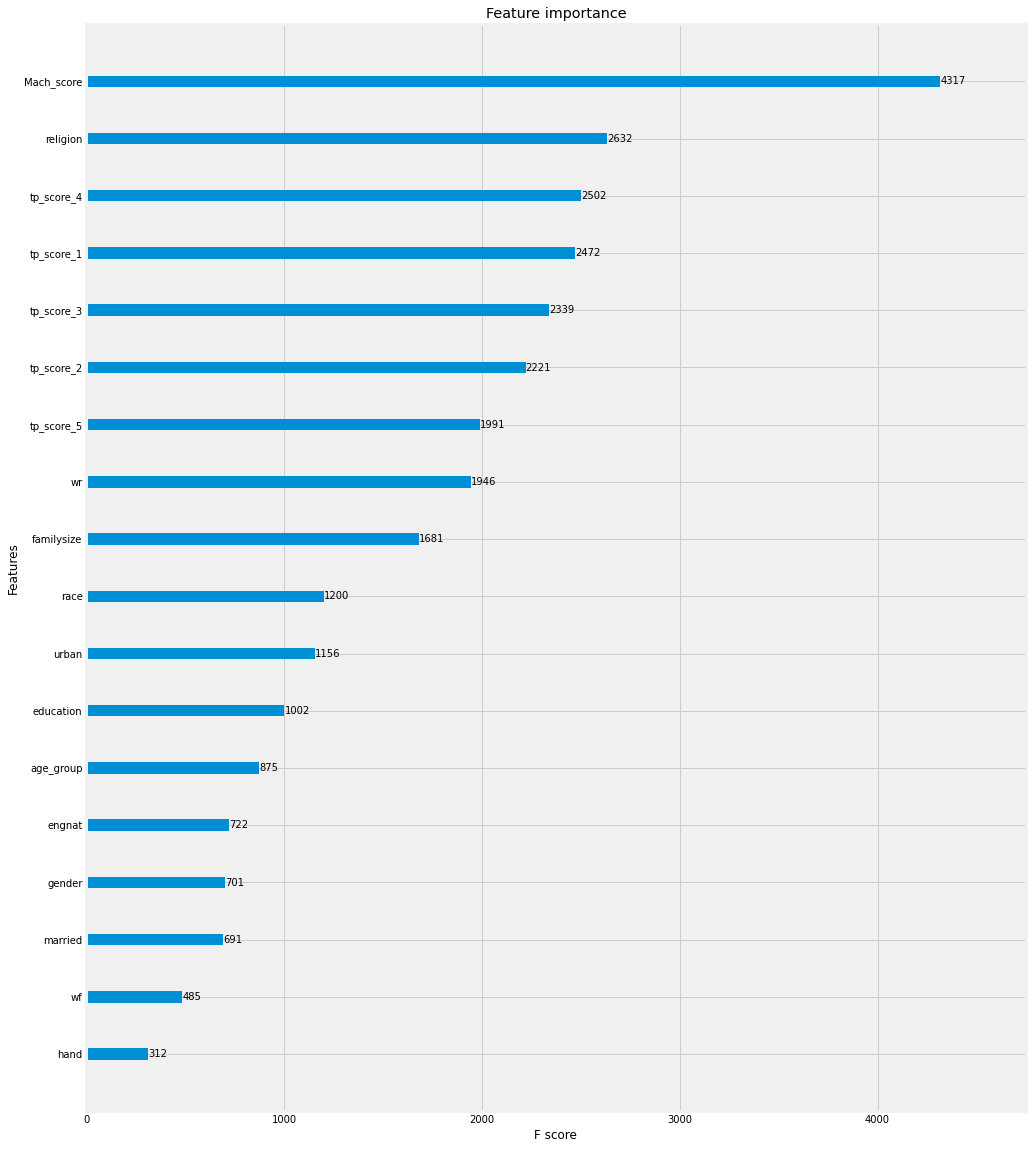

In [28]:
fig, ax = plt.subplots(figsize=(15,20))
plot_importance(model1, ax=ax)

In [29]:
def xgb_pred_per(param, bad_arr):
    
    train_x = preprocess(train,'train',bad_arr)
    train_y = train_x['voted']
    train_x = train_x.drop(['voted'],axis=1)
    test_x = preprocess(test,'test',bad_arr)

    model = XGBClassifier(**param)
    
    start_train = time.time()
    model.fit(train_x,train_y, verbose=False)
    print(f'Training : {time.time()-start_train:.2f}s')
    
    print(f'{param["max_depth"]}_{param["n_estimators"]}_{param["learning_rate"]:.3f}_{param["min_child_weight"]:02d}_{param["colsample_bytree"]:.2f}', end=' ')
    pred_auc = train_auc([model], train_x, train_y)
    print(f'{pred_auc:.4f}')
    file_name = f'xgb_{param["max_depth"]}_{param["n_estimators"]}_{param["learning_rate"]:.3f}_{param["min_child_weight"]:02d}_{param["colsample_bytree"]:.2f}_{pred_auc:.4f}'
    submission(test_x,[model],file_name)
    
    return model

In [30]:
opt = { 'max_depth' : 8,
        'n_estimators' : 200,
        'learning_rate' : 0.010,
         'min_child_weight' : 6,
         'colsample_bytree' : 0.8,
        'verbosity' : 0,
        'objective' : 'binary:logistic',
        'booster' : 'gbtree',
        'subsample' : 0.8}

In [39]:
model2 = xgb_pred_per(opt,['tp_score_4','wf','hand'])

Training : 2.04s
8_200_0.010_06_0.80 0.8034


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

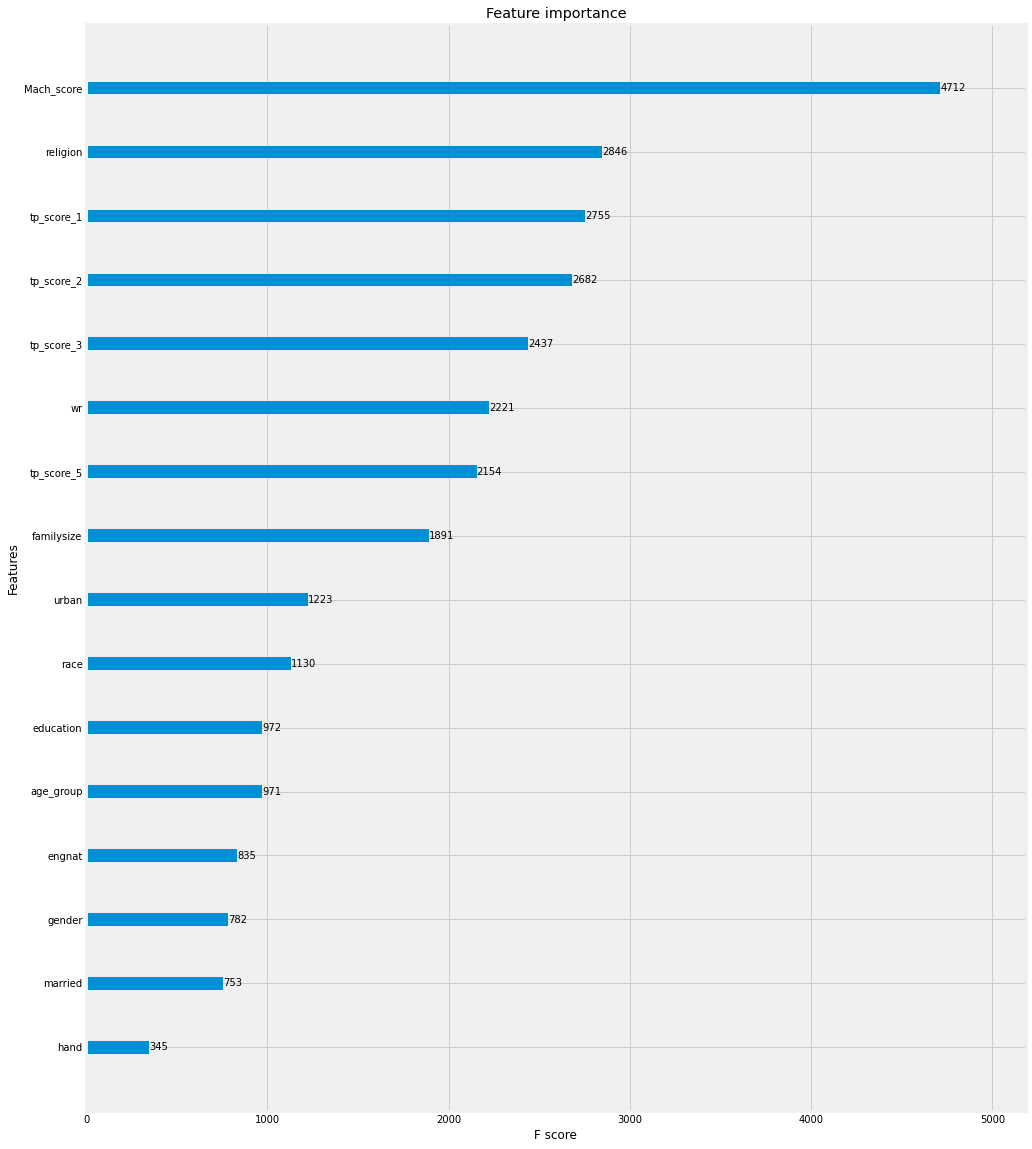

In [38]:
fig, ax = plt.subplots(figsize=(15,20))
plot_importance(model2, ax=ax)

In [55]:
def xgb_pred_bo(max_depth, n_estimators, learning_rate, weight, col_sample, subsample, reg_l, reg_a):
    
    train_x = preprocess(train,'train')
    train_y = train_x['voted']
    train_x = train_x.drop(['voted'],axis=1)
    test_x = preprocess(test,'test')
    
    param = { 'max_depth' : max_depth, 
            'n_estimators' : n_estimators,
            'learning_rate' : learning_rate,
            'min_child_weight' : weight,
            'colsample_bytree' : col_sample,
            'subsample' : subsample,
            'reg_lambda' : reg_l,
            'reg_alpha' : reg_a,
            'verbosity' : 0,
            'objective' : 'binary:logistic',
            'booster' : 'gbtree'
            }

    model = XGBClassifier(**param)
    model.fit(train_x,train_y, verbose=False)
    
    print(f'{max_depth}_{n_estimators}_{learning_rate:.3f}_{weight:02d}_{col_sample:.2f}_{subsample:.2f}_{reg_l:.2f}_{reg_a:.2f} : ', end=' ')
    pred_auc = train_auc([model], train_x, train_y)
    print(f'{pred_auc:.4f}')
    file_name = f'xgb_bo_{max_depth}_{n_estimators}_{learning_rate:.3f}_{weight:02d}_{col_sample:.2f}_{subsample:.2f}_{reg_l:.2f}_{reg_a:.2f}_{pred_auc:.4f}'
    submission(test_x,[model],file_name)
    
    return model

In [56]:
model2 = xgb_pred_bo(max_depth=4, n_estimators=569, learning_rate=0.11, weight=48, col_sample=0.23, subsample=0.80, reg_l=0.38, reg_a=0.92)

4_569_0.110_48_0.23_0.80_0.38_0.92 :  0.7874


# LightGBM

In [43]:
def lgbm(param,bad_arr):

    train_x = preprocess(train,'train',bad_arr)
    train_y = train_x['voted']
    train_x = train_x.drop(['voted'],axis=1)
    test_x = preprocess(test,'test',bad_arr)
    
    model = LGBMClassifier(**param)
    model.fit(train_x,train_y, verbose=False)


    print(f'{param["max_depth"]}_{param["num_leaves"]}_{param["n_estimators"]}_{param["learning_rate"]:.3f}_{param["min_child_weight"]:02d}_{param["colsample_bytree"]:.2f}_{param["feature_fraction"]:.2f}_{param["bagging_fraction"]:.2f}_{param["lambda_l1"]:.2f}_{param["lambda_l2"]:.2f} : ', end=' ')
    pred_auc = train_auc([model], train_x, train_y)
    print(f'{pred_auc:.4f}')
    file_name = f'lgbm_{param["max_depth"]}_{param["num_leaves"]}_{param["n_estimators"]}_{param["learning_rate"]:.3f}_{param["min_child_weight"]:02d}_{param["colsample_bytree"]:.2f}_{param["feature_fraction"]:.2f}_{param["bagging_fraction"]:.2f}_{param["lambda_l1"]:.2f}_{param["lambda_l2"]:.2f}_{pred_auc:.4f}'
    submission(test_x,[model],file_name)
    
    return model

In [44]:
lgbm_opt= { 'max_depth' : 5, 
            'num_leaves' : 359,
            'n_estimators' : 581,
            'learning_rate' : 0.05,
            'min_child_weight' : 37,
            'colsample_bytree' : 0.67,
            'feature_fraction' : 0.77,
            'bagging_fraction' : 0.91,
            'lambda_l1' : 0.41,
            'lambda_l2' : 0.09,
            'objective' : 'binary',
            'boosting_type' : 'dart'
            }

In [49]:
model2 = lgbm(lgbm_opt,['tp_score_2'])

[LightGBM] [Warning] feature_fraction is set=0.77, colsample_bytree=0.67 will be ignored. Current value: feature_fraction=0.77
[LightGBM] [Warning] lambda_l1 is set=0.41, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.41
[LightGBM] [Warning] bagging_fraction is set=0.91, subsample=1.0 will be ignored. Current value: bagging_fraction=0.91
[LightGBM] [Warning] lambda_l2 is set=0.09, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.09
5_359_581_0.050_37_0.67_0.77_0.91_0.41_0.09 :  0.7853


# Ensemble

In [79]:
def ensemble(xgb_params, lgbm_params, r):
    
    n1 = len(xgb_params)
    n2 = len(lgbm_params)
    num_model = len(r)
    
    assert (n1+n2 == num_model), 'Num mismatch'
    
    train_x = preprocess(train,'train')
    train_y = train_x['voted']
    train_x = train_x.drop(['voted'],axis=1)
    test_x = preprocess(test,'test')
    
    model_arr = []
    
    for i in range(n1): 
        model = XGBClassifier(**xgb_params[i])
        model.fit(train_x,train_y, verbose=False)
        model_arr.append(model)
        
    for i in range(n2):
        model = LGBMClassifier(**lgbm_params[i])
        model.fit(train_x,train_y, verbose=False)
        model_arr.append(model)
    
    score = np.zeros((test_x.shape[0],2))
    for i in range(num_model):
        score += model_arr[i].predict_proba(test_x)*r[i]

    data = {'index':test['index'],'voted':score[:,1]}
    submission = DataFrame(data)
    
    file_name = 'ensemble'
    for i in range(num_model):
        file_name = file_name + f'_{r[i]}'
        
    submission.to_csv('./submission/'+file_name+'.csv',index=False)

    return model_arr

In [83]:
xgb_1 = { 'max_depth' : 8,
        'n_estimators' : 200,
        'learning_rate' : 0.01,
         'min_child_weight' : 6,
         'colsample_bytree' : 0.8,
        'verbosity' : 0,
        'objective' : 'binary:logistic',
        'booster' : 'gbtree',
        'subsample' : 0.8}

xgb_2 = { 'max_depth' : 8,
        'n_estimators' : 250,
        'learning_rate' : 0.01,
         'min_child_weight' : 1,
         'colsample_bytree' : 0.8,
        'verbosity' : 0,
        'objective' : 'binary:logistic',
        'booster' : 'gbtree',
        'subsample' : 0.8}

lgbm_1 = { 'max_depth' : 5, 
            'num_leaves' : 359,
            'n_estimators' : 581,
            'learning_rate' : 0.05,
            'min_child_weight' : 37,
            'colsample_bytree' : 0.67,
            'feature_fraction' : 0.77,
            'bagging_fraction' : 0.91,
            'lambda_l1' : 0.41,
            'lambda_l2' : 0.09,
            'objective' : 'binary',
            'boosting_type' : 'dart'
            }

lgbm_2 = { 'max_depth' : 5, 
            'num_leaves' : 359,
            'n_estimators' : 581,
            'learning_rate' : 0.05,
            'min_child_weight' : 37,
            'colsample_bytree' : 0.67,
            'feature_fraction' : 0.77,
            'bagging_fraction' : 0.91,
            'lambda_l1' : 0.41,
            'lambda_l2' : 0.09,
            'objective' : 'binary',
            'boosting_type' : 'dart'
            }

In [85]:
arr = ensemble([xgb_1,xgb_2], [lgbm_1], [0.21, 0.63, 0.16])

[LightGBM] [Warning] feature_fraction is set=0.77, colsample_bytree=0.67 will be ignored. Current value: feature_fraction=0.77
[LightGBM] [Warning] lambda_l1 is set=0.41, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.41
[LightGBM] [Warning] bagging_fraction is set=0.91, subsample=1.0 will be ignored. Current value: bagging_fraction=0.91
[LightGBM] [Warning] lambda_l2 is set=0.09, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.09
